In [1]:
from fastai.vision.all import *


from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import wandb
from fastai.callback.wandb import WandbCallback

C:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
wandb.init(project='segmentation_test', entity='jdconey')

wandb: Currently logged in as: jdconey (use `wandb login --relogin` to force relogin)


In [3]:
codes = np.array(['none','wave'])
path = 'C:/Users/mm16jdc/Documents/CEDA_satellites/pytorch_mask_test/images_3/'
#path_lbl = path+'/masks/'
#path_img = path+'/images/'

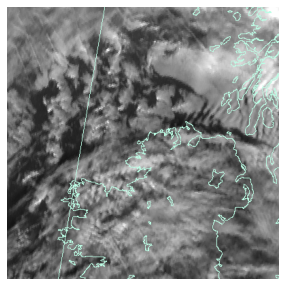

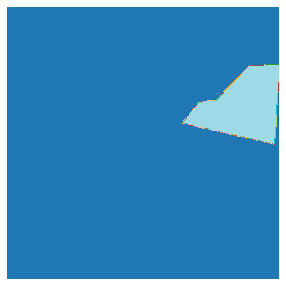

In [4]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

get_msk = lambda o: path_lbl+f'{o.stem}{o.suffix}'

msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

sz = msk.shape
half = tuple(int(x/2) for x in sz)

In [5]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


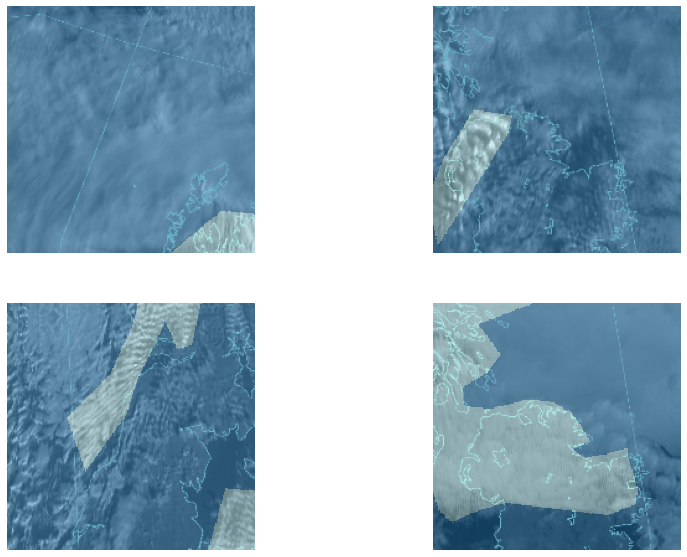

In [20]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter= GrandparentSplitter(train_name=('train', 'valid'), valid_name='test'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

dls = camvid.dataloaders(path+'/images', bs=8)
dls.show_batch(max_n=4, vmin=0, vmax=1, figsize=(14,10))

dls.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}
void_code = ''

In [21]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()


In [22]:
opt = ranger
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)

In [23]:
lr = 1e-3
learn.fit_flat_cos(10,slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.375643,None,None,16:05
1,0.302546,None,None,16:14
2,0.277649,None,None,15:48
3,0.269947,None,None,15:40


KeyboardInterrupt: 

In [11]:
camvid

Setting-up type transforms pipelines
Found 491 items
2 datasets of sizes 491,0
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\mm16jdc\Documents\CEDA_satellites\pytorch_mask_test\images_3\train\images\0.png
    applying PILBase.create gives
      PILImage mode=RGB size=400x400
  Pipeline: <lambda> -> PILBase.create
    starting from
      C:\Users\mm16jdc\Documents\CEDA_satellites\pytorch_mask_test\images_3\train\images\0.png
    applying <lambda> gives
      C:/Users/mm16jdc/Documents/CEDA_satellites/pytorch_mask_test/images_3/train/masks/0.png
    applying PILBase.create gives
      PILMask mode=L size=400x400

Final sample: (PILImage mode=RGB size=400x400, PILMask mode=L size=400x400)


Found 491 items
2 datasets of sizes 491,0
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Due to IPython and Windows limitation, python multiprocess

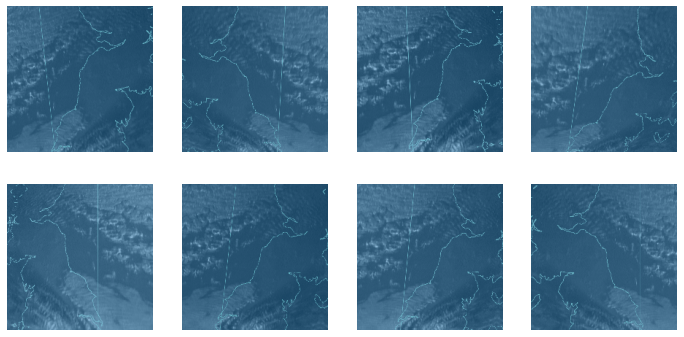

In [16]:
camvid.summary(path+"/images", bs=8, show_batch=True, unique=True)